In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from scipy.stats import rankdata

import scipy.spatial
from itertools import combinations
from scipy.spatial.distance import pdist
from scipy import optimize

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

In [2]:
plt.style.use('ggplot')

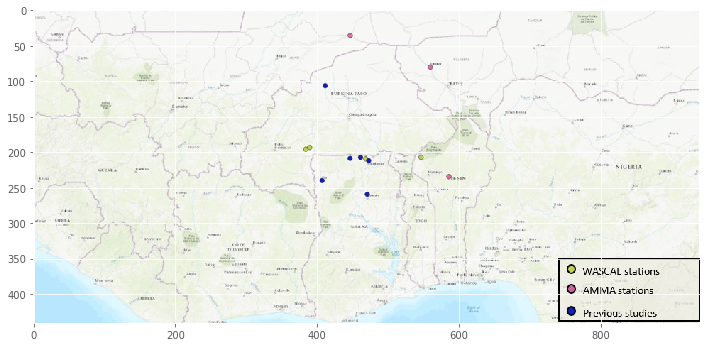

In [3]:
img1 = plt.imread('Data/location.jpg')

plt.figure(figsize = (12, 8))
plt.imshow(img1);

In [3]:
locations = pd.read_csv('Data\stations.txt', sep=' ', index_col=0)

locations.head(20)

,database,station_latitude(dec.degree),station_longitude(dec.degree),station_altitude(m)
station_name,,,,
TILLABERI,AMMA-CATCH,14.204300,1.454500,212.0
TOBRE,AMMA-CATCH,10.199100,2.133500,371.0
TARA,AMMA-CATCH,15.251400,-1.585500,335.0
AGOUFOU,AMMA-CATCH,15.360000,-1.470000,340.0
LAWRA,MARLOES,10.866670,-1.483330,305.0
NAVRONGO,MARLOES,10.530000,-1.050000,201.3
OUAHIGOUYA,MARLOES,13.520000,-2.390000,365.0
TAMALE,MARLOES,9.330000,-0.510000,183.3
WA,MARLOES,10.030000,-2.090000,322.7


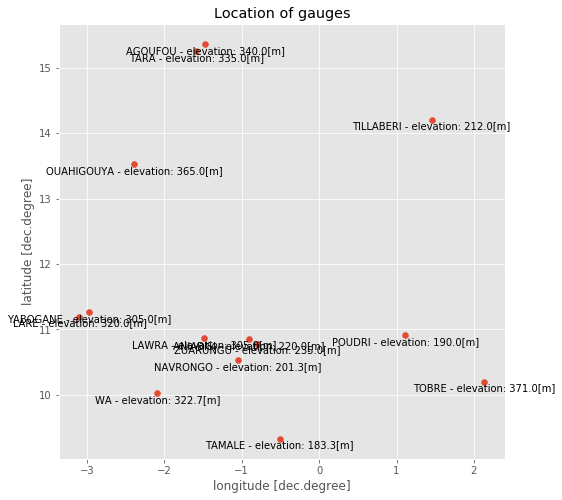

In [4]:
plt.figure(figsize=(8, 8))

plt.scatter(locations['station_longitude(dec.degree)'], locations['station_latitude(dec.degree)'])

for i in range(len(locations)):
    plt.text(locations['station_longitude(dec.degree)'][i], locations['station_latitude(dec.degree)'][i]  - 0.1, locations.index[i] + ' - elevation: ' + str(locations['station_altitude(m)'][i]) + '[m]', horizontalalignment='center', verticalalignment='center')

plt.xlabel('longitude [dec.degree]')
plt.ylabel('latitude [dec.degree]')
plt.title('Location of gauges')

plt.savefig('DataFigures/Location of gauges.png');

In [6]:
# Calculate the euclidean distance between each coordinate pair

all_distances = pdist(np.array(list(zip(locations['station_longitude(dec.degree)'], locations['station_latitude(dec.degree)']))))
print(f'All the distances are {len(all_distances):.0f}.')

all_distances = all_distances * 111.32  # dec. degrees to kms

# print(all_distances)

All the distances are 91.


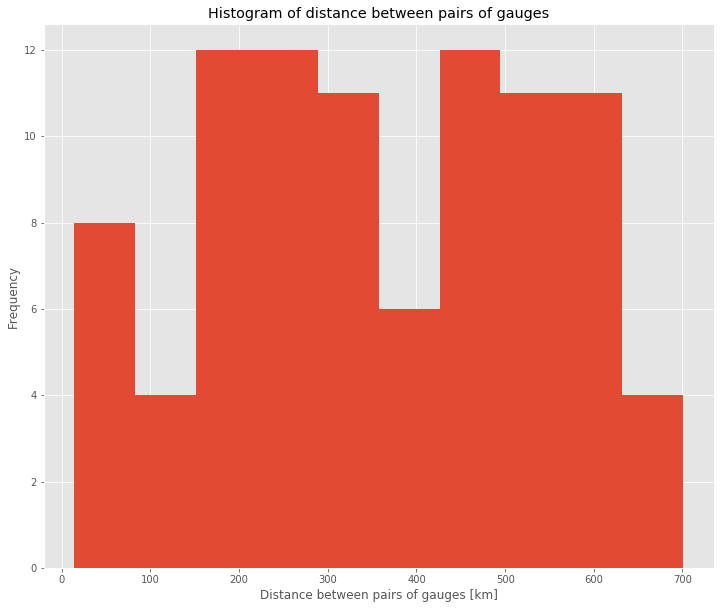

In [7]:
# Histogram

plt.figure(figsize=(12, 10))

plt.hist(all_distances, bins=10, density=False, histtype='stepfilled')
plt.xlabel('Distance between pairs of gauges [km]')
plt.ylabel('Frequency')
plt.title('Histogram of distance between pairs of gauges')

plt.savefig('DataFigures/Histogram of distance between pairs of gauges.png');

In [8]:
print(f'The smallest distance between pair of gauges is {min(all_distances):.2f} km.')
print(' ')
print(f'The largest distance between pair of gauges is {max(all_distances):.2f} km.')

The smallest distance between pair of gauges is 14.22 km.
 
The largest distance between pair of gauges is 700.70 km.


In [9]:
less50 = len(all_distances[all_distances < 50])
abv500 = len(all_distances[all_distances > 500])

       
print(f'The number of distancse between pair of gauges smaller than 50 km are {less50:.0f}.')
print(' ')
print(f'The number of distancse between pair of gauges larger than 500 km are {abv500:.0f}.')

The number of distancse between pair of gauges smaller than 50 km are 5.
 
The number of distancse between pair of gauges larger than 500 km are 22.


# Spatial analysis
## Load datasets

In [12]:
# load the time-series 

TILLABERI = pd.read_csv("OrganisedData\Gauges\stationTILLABERI.csv", index_col=0)
TOBRE = pd.read_csv("OrganisedData\Gauges\stationTOBRE.csv", index_col=0)
TARA = pd.read_csv("OrganisedData\Gauges\stationTARA.csv", index_col=0)
AGOUFOU = pd.read_csv("OrganisedData\Gauges\stationAGOUFOU.csv", index_col=0)
LAWRA = pd.read_csv("OrganisedData\Gauges\stationLAWRA.csv", index_col=0)
NAVRONGO = pd.read_csv("OrganisedData\Gauges\\stationNAVRONGO.csv", index_col=0)
OUAHIGOUYA = pd.read_csv("OrganisedData\Gauges\stationOUAHIGOUYA.csv", index_col=0)
TAMALE = pd.read_csv("OrganisedData\Gauges\stationTAMALE.csv", index_col=0)
WA = pd.read_csv("OrganisedData\Gauges\stationWA.csv", index_col=0)
ZUARUNGU = pd.read_csv("OrganisedData\Gauges\stationZUARUNGU.csv", index_col=0)
ANIABISI = pd.read_csv("OrganisedData\Gauges\stationANIABISI.csv", index_col=0)
POUDRI = pd.read_csv("OrganisedData\Gauges\stationPOUDRI.csv", index_col=0)
LARE = pd.read_csv("OrganisedData\Gauges\stationLARE.csv", index_col=0)
YABOGANE = pd.read_csv("OrganisedData\Gauges\stationYABOGANE.csv", index_col=0)

# AGOUFOU.head(10000)

In [13]:
# load the .csv 

TILLABERIsat1 = pd.read_csv("OrganisedData\MSWEP\TILLABERIsat1.csv", index_col=0)
TOBREsat1 = pd.read_csv("OrganisedData\MSWEP\TOBREsat1.csv", index_col=0)
TARAsat1 = pd.read_csv("OrganisedData\MSWEP\TARAsat1.csv", index_col=0)
AGOUFOUsat1 = pd.read_csv("OrganisedData\MSWEP\AGOUFOUsat1.csv", index_col=0)
LAWRAsat1 = pd.read_csv("OrganisedData\MSWEP\LAWRAsat1.csv", index_col=0)
NAVRONGOsat1 = pd.read_csv("OrganisedData\MSWEP\\NAVRONGOsat1.csv", index_col=0)
OUAHIGOUYAsat1 = pd.read_csv("OrganisedData\MSWEP\OUAHIGOUYAsat1.csv", index_col=0)
TAMALEsat1 = pd.read_csv("OrganisedData\MSWEP\TAMALEsat1.csv", index_col=0)
WAsat1 = pd.read_csv("OrganisedData\MSWEP\WAsat1.csv", index_col=0)
ZUARUNGUsat1 = pd.read_csv("OrganisedData\MSWEP\ZUARUNGUsat1.csv", index_col=0)
ANIABISIsat1 = pd.read_csv("OrganisedData\MSWEP\ANIABISIsat1.csv", index_col=0)
POUDRIsat1 = pd.read_csv("OrganisedData\MSWEP\POUDRIsat1.csv", index_col=0)
LAREsat1 = pd.read_csv("OrganisedData\MSWEP\LAREsat1.csv", index_col=0)
YABOGANEsat1 = pd.read_csv("OrganisedData\MSWEP\YABOGANEsat1.csv", index_col=0)

# ZUARUNGUsat1.head(10000)

In [14]:
def get_semivariogram(bin_width, cutoff, all_distances, squared_differences):
    bins = np.arange(bin_width, cutoff+1, bin_width)
    n_bins = len(bins)
    sv_holder = np.zeros((1,n_bins))[0]
    n_holder = np.zeros((1,n_bins))[0]
    for i, cur_t in enumerate(bins):
        mask = (all_distances>bins[i]-bin_width) & (all_distances<=bins[i])
        n_holder[i] = np.sum(mask)
        sv_holder[i] =  0.5*np.nanmean(squared_differences[mask])
    return bins, sv_holder, n_holder

# Temporal variogram

In [26]:
TILLABERI.index = pd.to_datetime(TILLABERI.index, dayfirst=True)  # dates need to be at the right format

all_time_gauge = np.array([(b-a) for a, b in combinations(TILLABERI.index, 2)])
squared_differences_time = np.array([(b-a)**2 for a, b in combinations(TILLABERI['R[mm]'], 2)])

In [31]:
time = np.empty(len(all_time_gauge))
for i in range(len(all_time_gauge)):
    time[i] = all_time_gauge[i].days # days
    
print(len(time))

21612025


In [59]:
# temporal semivariogram

bin_width = 40  # need perfect balance between too much and too less info
cutoff = int(np.round(0.04 * max(time)))  # after multiple trials

variogram_temporal = get_semivariogram(bin_width, cutoff, time, squared_differences_time)

In [60]:
# 1. Create an array with the center of each bin
        
xv = np.zeros(len(variogram_temporal[0]))
xv[0] = bin_width / 2  # the first value

for i in range(1, len(variogram_temporal[0])):
    xv[i] = xv[i-1] + bin_width
    
# print(xv)

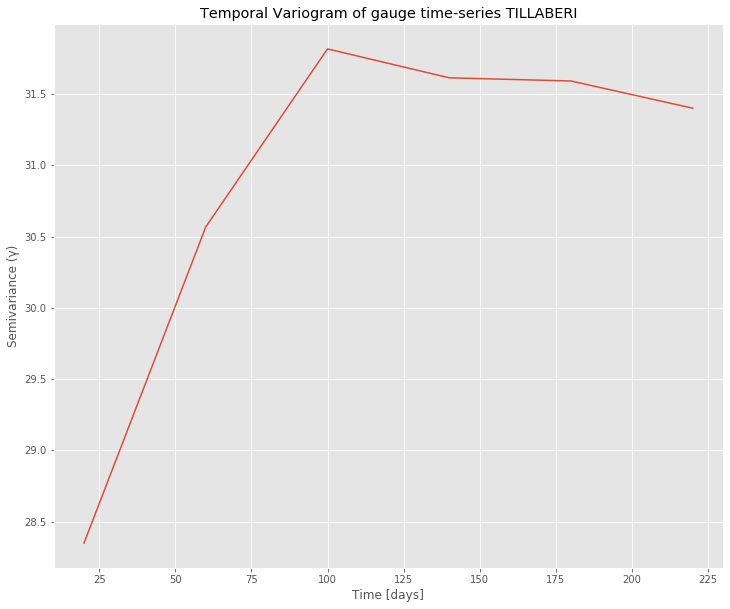

In [61]:
plt.figure(figsize=(12, 10))

plt.plot(xv , variogram_temporal[1]) 
plt.xlabel('Time [days]')
plt.ylabel('Semivariance (γ)')
plt.title('Temporal Variogram of gauge time-series TILLABERI');

# plt.savefig('DataFigures/Temporal Variogram of gauge time-series TILLABERI.png');

# Elevation and variance

In [66]:
elv = np.array(locations['station_altitude(m)'])

elv

array([212. , 371. , 335. , 340. , 305. , 201.3, 365. , 183.3, 322.7,
       235. , 220. , 190. , 320. , 305. ])

In [70]:
CV = np.zeros(len(elv))

CV[0] = TILLABERI['R[mm]'].std() / TILLABERI['R[mm]'].mean()
CV[1] = TOBRE['R[mm]'].std() / TOBRE['R[mm]'].mean()
CV[2] = TARA['R[mm]'].std() / TARA['R[mm]'].mean()
CV[3] = AGOUFOU['R[mm]'].std() / AGOUFOU['R[mm]'].mean()
CV[4] = LAWRA['R[mm]'].std() / LAWRA['R[mm]'].mean()
CV[5] = NAVRONGO['R[mm]'].std() / NAVRONGO['R[mm]'].mean()
CV[6] = OUAHIGOUYA['R[mm]'].std() / OUAHIGOUYA['R[mm]'].mean()
CV[7] = TAMALE['R[mm]'].std() / TAMALE['R[mm]'].mean()
CV[8] = WA['R[mm]'].std() / WA['R[mm]'].mean()
CV[9] = ZUARUNGU['R[mm]'].std() / ZUARUNGU['R[mm]'].mean()
CV[10] = ANIABISI['R[mm]'].std() / ANIABISI['R[mm]'].mean()
CV[11] = POUDRI['R[mm]'].std() / POUDRI['R[mm]'].mean()
CV[12] = LARE['R[mm]'].std() / LARE['R[mm]'].mean()
CV[13] = YABOGANE['R[mm]'].std() / YABOGANE['R[mm]'].mean()

CV

array([5.07190913, 3.02444981, 4.17885854, 4.18443194, 3.26885245,
       3.32640798, 3.87262164, 3.14713467, 2.95126035, 3.24972722,
       3.27361999, 3.16169773, 3.28572099, 3.24987308])

In [71]:
# correlation estimation

rho = np.corrcoef(elv, CV)
p = rho[0][1]
r, pvalue = spearmanr(elv, CV)

In [72]:
print(f'The Pearson product moment correlation of the samples is equal to {p:.3f}.')
print(' ')
print(f'The Spearman rank correlation of the samples is equal to {r:.3f}.')

The Pearson product moment correlation of the samples is equal to 0.036.
 
The Spearman rank correlation of the samples is equal to 0.119.


# Compare to stations in same region

In [63]:
TILLABERI

,R[mm]
Date,
1999-01-01,0.0
1999-01-02,0.0
1999-01-03,0.0
1999-01-04,0.0
1999-01-05,0.0
...,...
2016-12-27,0.0
2016-12-28,0.0
2016-12-29,0.0


In [64]:
TARA

,R[mm]
Date,
2004-05-01,0.0
2004-05-02,0.0
2004-05-03,0.0
2004-05-04,0.0
2004-05-05,0.0
...,...
2017-12-27,0.0
2017-12-28,0.0
2017-12-29,0.0


In [65]:
ind1 = np.where(TILLABERI.index == TARA.index)
ind1

ValueError: Lengths must match